<a href="https://colab.research.google.com/github/Kerdthip/Hand-Gesture-Classification-Algorithm/blob/main/One_Position_Gesture_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>
# Tiny ML on Arduino
## Gesture recognition tutorial
 * Sandeep Mistry - Arduino
 * Don Coleman - Chariot Solutions

 
https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

## Setup Python Environment 

The next cell sets up the dependencies in required for the notebook, run it.

In [ ]:
# Setup environment
!apt-get update
!apt-get -qq install xxd
#!pip install pandas numpy matplotlib
#!pip install tensorflow==2.8.0rc0

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/

# Upload Data

1. Open the panel on the left side of Colab by clicking on the __>__
1. Select the files tab
1. Drag `punch.csv` and `flex.csv` files from your computer to the tab to upload them into colab.

# Graph Data (optional)

We'll graph the input files on two separate graphs, acceleration and gyroscope, as each data set has different units and scale.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

d_plot={}

GESTURES = [
    "Call",
    "Fist",
    "Left",
    "Rest",
    "Right",
]

SAMPLES_PER_GESTURE = 740
NUM_GESTURES = len(GESTURES)

for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]  
  
  df = pd.read_csv("/content/" + gesture + ".csv")
  df.fillna(df.mean())
  
  d_plot[gesture] = df.values.reshape(-1,740)

In [ ]:
def plot_six(start,gesture='Fist'):
  pl = d_plot[gesture]

  fig, axes = plt.subplots(2,3, frameon = False)
  plt.rcParams["figure.figsize"] = (16,8)
  fig.subplots_adjust(hspace = .15, wspace=0)

  for ax, d in zip(axes.ravel(), pl[start:start+6]):
    SAMPLES_PER_GESTURE = 740
    sns.lineplot(data = d, linestyle='solid', marker=',', ax=ax)
    ax.set_ylim([0,pl[start:start+6].max()+20])
    ax.set_xlim([-10,SAMPLES_PER_GESTURE+10])
    ax.get_yaxis().set_visible(False)
    ax.grid(False)


  axes.ravel()[0].get_yaxis().set_visible(True)
  axes.ravel()[3].get_yaxis().set_visible(True)
  fig.suptitle("Acceleration (G)",y=0.92)
  sns.axes_style("whitegrid")

def plot_layer(start,gesture='Fist'):
  pl = d_plot[gesture]

  plt.rcParams["figure.figsize"] = (20,8)
  for d in pl[start:start+3]:
    SAMPLES_PER_GESTURE = 740
    sns.lineplot(data = d, linestyle='solid', marker=',')
  plt.ylim([pl[start:start+3].min(),pl[start:start+3].max()+20])
  plt.xlim([0,SAMPLES_PER_GESTURE])
  plt.title('Compare Acceleration (G)')
  sns.axes_style("whitegrid")

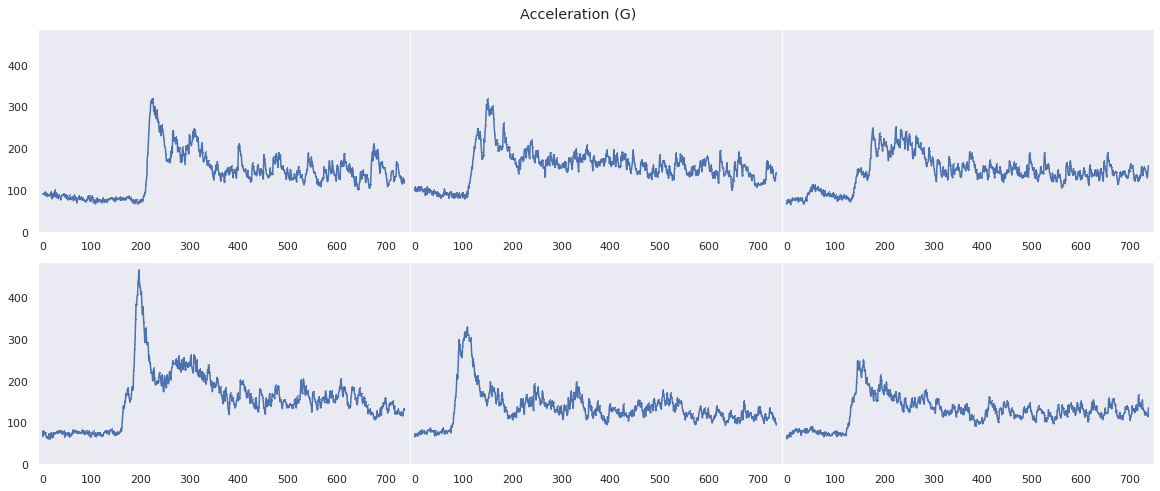

In [ ]:
plot_six(20,'Fist')

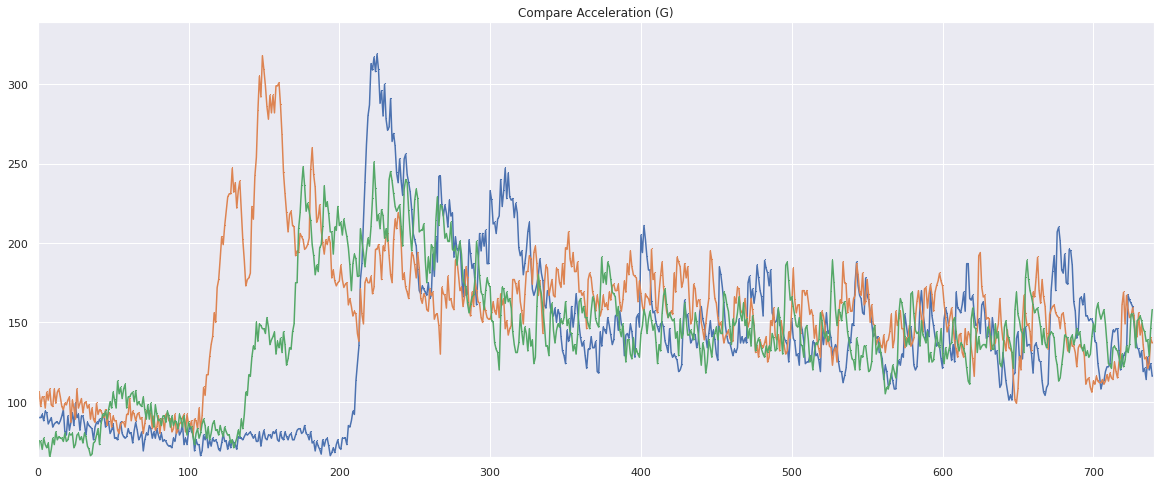

In [ ]:
plot_layer(20,'Fist')

# Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

Update the `GESTURES` list with the gesture data you've collected in `.csv` format.


In [ ]:
print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "Call",
    "Fist",
    "Left",
    "Rest",
    "Right"
    ]

SAMPLES_PER_GESTURE = 740

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
d_plot={}
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv("/content/" + gesture + ".csv").fillna(df.mean())
  
  d_plot[gesture] = df.values.reshape(-1,740)
  print(df.shape)
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 1000,
          #(df['aY'][index] + 4) / 8,
          #(df['aZ'][index] + 4) / 8,
          #(df['gX'][index] + 2000) / 4000,
          #(df['gY'][index] + 2000) / 4000,
          #(df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.8.0

Processing index 0 for gesture 'Call'.
(22940, 1)
	There are 31 recordings of the Call gesture.
Processing index 1 for gesture 'Fist'.
(22200, 1)
	There are 30 recordings of the Fist gesture.
Processing index 2 for gesture 'Left'.
(29600, 1)
	There are 40 recordings of the Left gesture.
Processing index 3 for gesture 'Rest'.
(25900, 1)
	There are 35 recordings of the Rest gesture.
Processing index 4 for gesture 'Right'.
(29600, 1)
	There are 40 recordings of the Right gesture.
Data set parsing and preparation complete.


In [ ]:
inputs[0]

array([ 0.035, 10.   ,  0.039, ..., 10.   ,  0.108, 10.   ])

## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [ ]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [ ]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=3, validation_data=(inputs_validate, outputs_validate))



Epoch 1/600
35/35 [==============================] - 1s 6ms/step - loss: 0.1446 - mae: 0.2961 - val_loss: 0.1162 - val_mae: 0.2457
Epoch 2/600
35/35 [==============================] - 0s 2ms/step - loss: 0.1169 - mae: 0.2519 - val_loss: 0.1081 - val_mae: 0.2220
Epoch 3/600
35/35 [==============================] - 0s 2ms/step - loss: 0.1042 - mae: 0.2302 - val_loss: 0.1101 - val_mae: 0.2130
Epoch 4/600
35/35 [==============================] - 0s 2ms/step - loss: 0.0956 - mae: 0.2128 - val_loss: 0.0979 - val_mae: 0.1960
Epoch 5/600
35/35 [==============================] - 0s 3ms/step - loss: 0.0870 - mae: 0.1983 - val_loss: 0.0846 - val_mae: 0.1860
Epoch 6/600
35/35 [==============================] - 0s 2ms/step - loss: 0.0794 - mae: 0.1870 - val_loss: 0.0874 - val_mae: 0.1758
Epoch 7/600
35/35 [==============================] - 0s 2ms/step - loss: 0.0707 - mae: 0.1724 - val_loss: 0.0910 - val_mae: 0.1796
Epoch 8/600
35/35 [==============================] - 0s 2ms/step - loss: 0.0614 - m

## Verify 

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

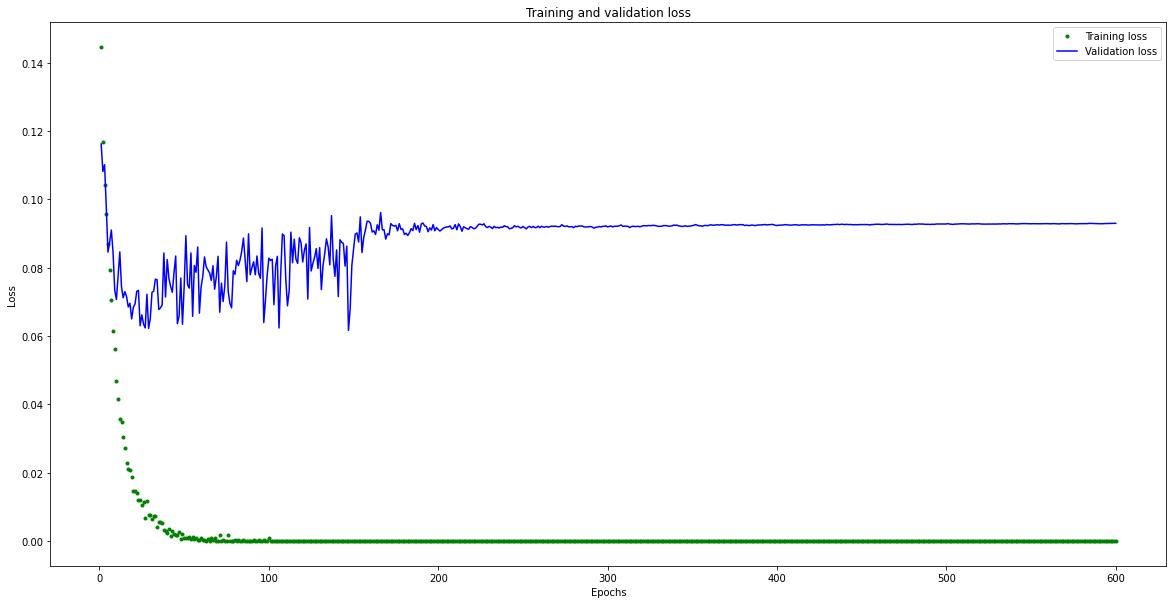

[20.0, 10.0]


In [ ]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Graph the loss again, skipping a bit of the start

We'll graph the same data as the previous code cell, but start at index 100 so we can further zoom in once the model starts to converge.

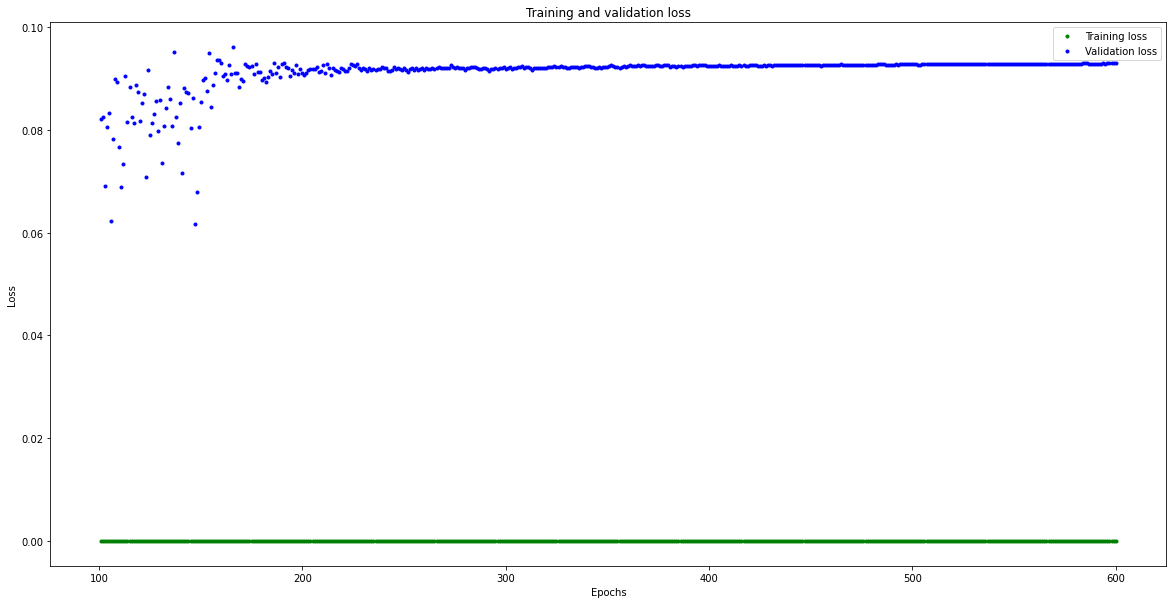

In [ ]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

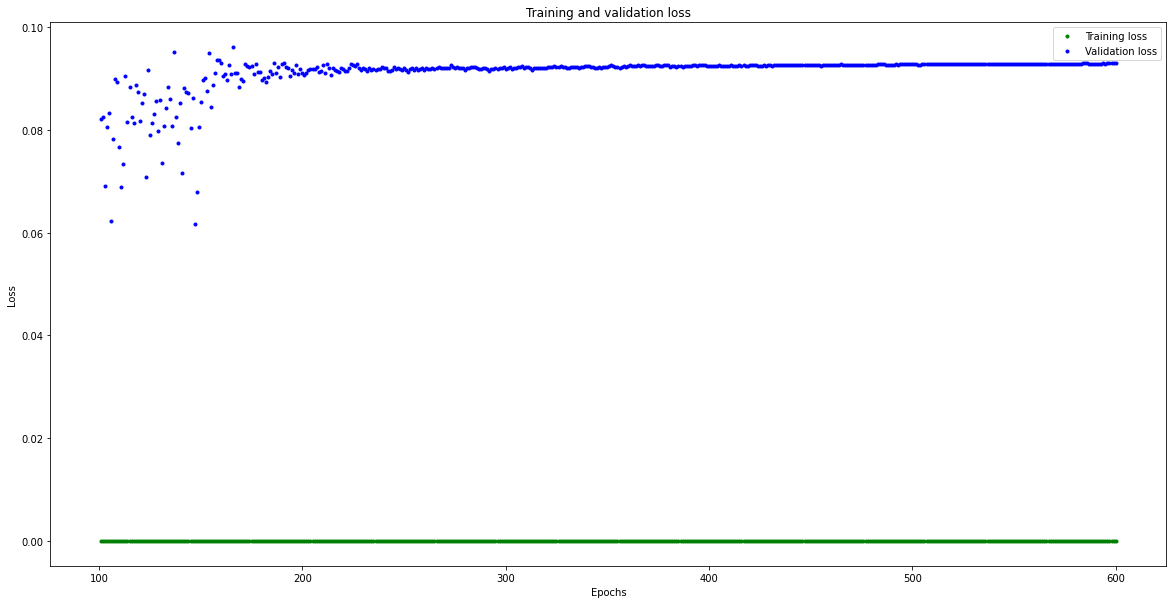

In [ ]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Graph the mean absolute error

[Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) is another metric to judge the performance of the model.



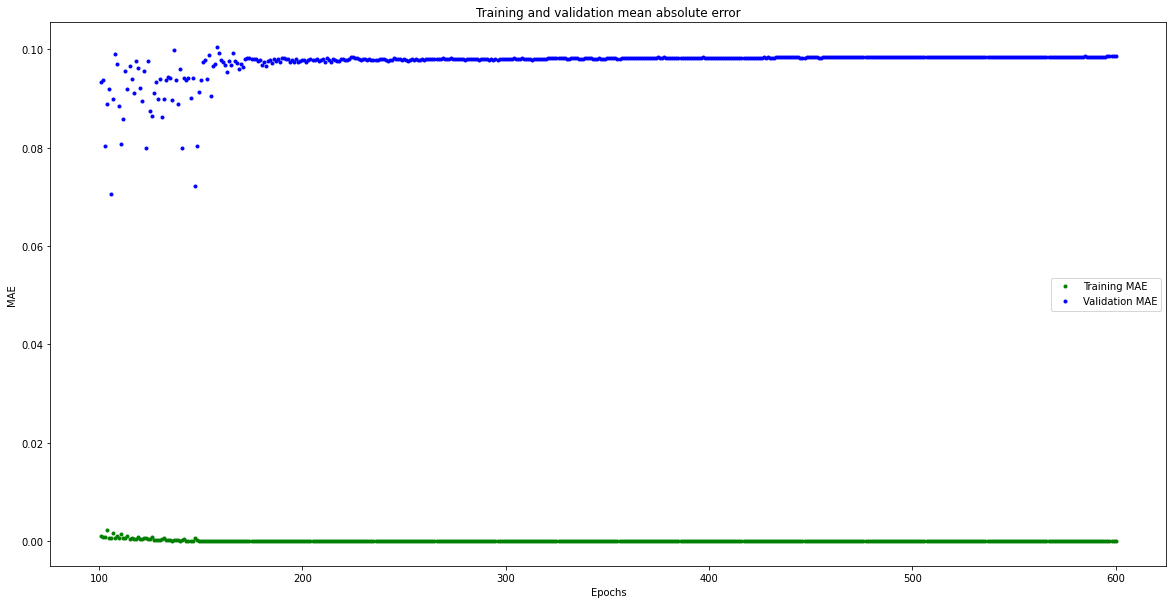

In [ ]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


### Run with Test Data
Put our test data into the model and plot the predictions


predictions =
 [2 4 4 2 1 0 3 1 1 1 1 1 4 1 2 4 3 4 4 3 2 0 4 3 1 2 2 4 4 0 0 0 4 4 2]
actual =
 [2 4 4 2 1 0 3 1 1 1 1 1 4 1 2 4 3 4 4 3 2 0 4 1 4 2 2 4 4 0 0 0 4 4 2]
Accuracy = 94.286 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  


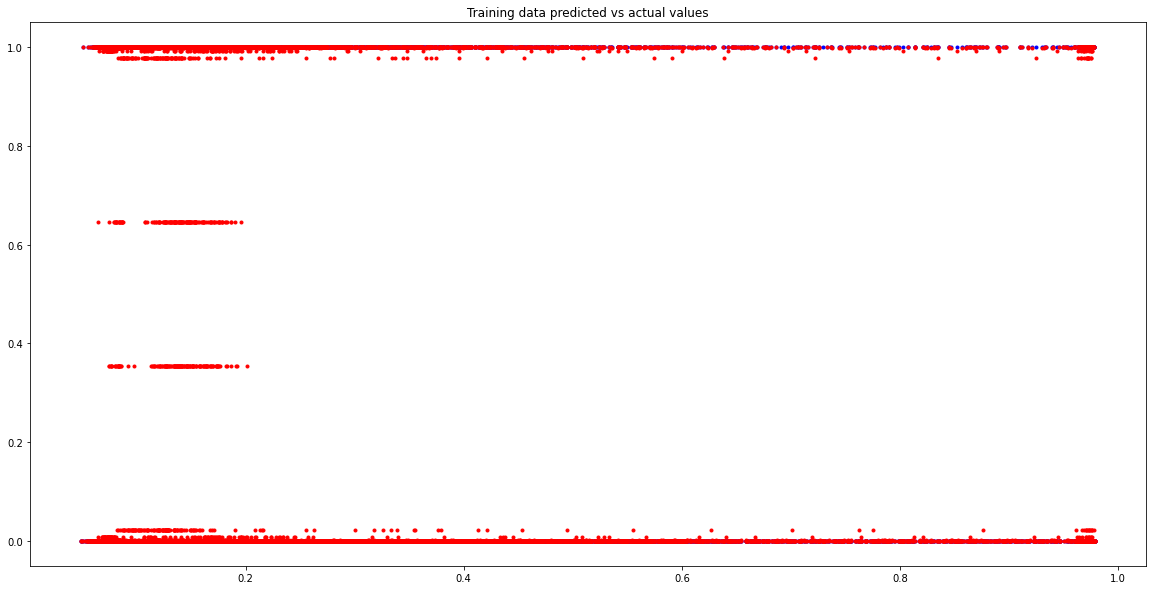

In [ ]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)
from sklearn.metrics import accuracy_score

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3).argmax(axis=1))
print("actual =\n", outputs_test.argmax(axis=1))
print(f"Accuracy = {accuracy_score(np.round(predictions, decimals=3).argmax(axis=1), outputs_test.argmax(axis=1))*100:.3f} %")

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
plt.plot(inputs_test, predictions, 'r.', label='Predicted')
plt.show()

In [ ]:
import seaborn as sns

# Plot the confusion matrix on specify dataset
def plot_confusion_matrix(label=outputs_train,data=inputs_train):
  confusion_matrix = tf.math.confusion_matrix(label.argmax(axis=1), model.predict(data).argmax(axis=1))
  sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
  sns.set(font_scale=1)

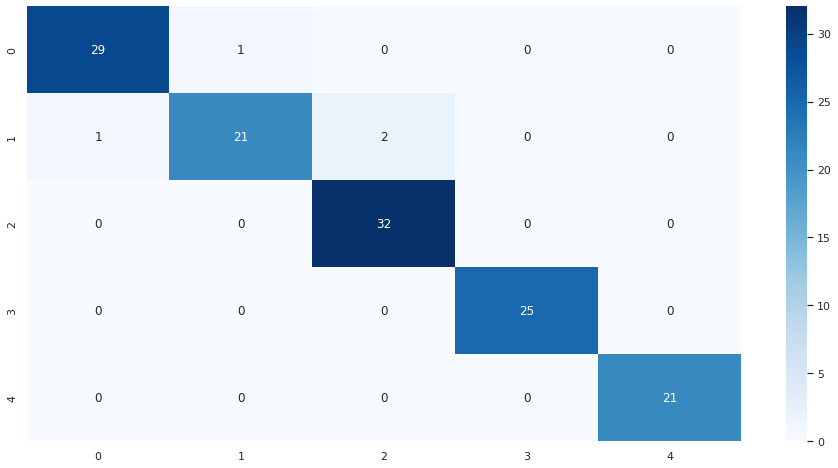

In [ ]:
plot_confusion_matrix()

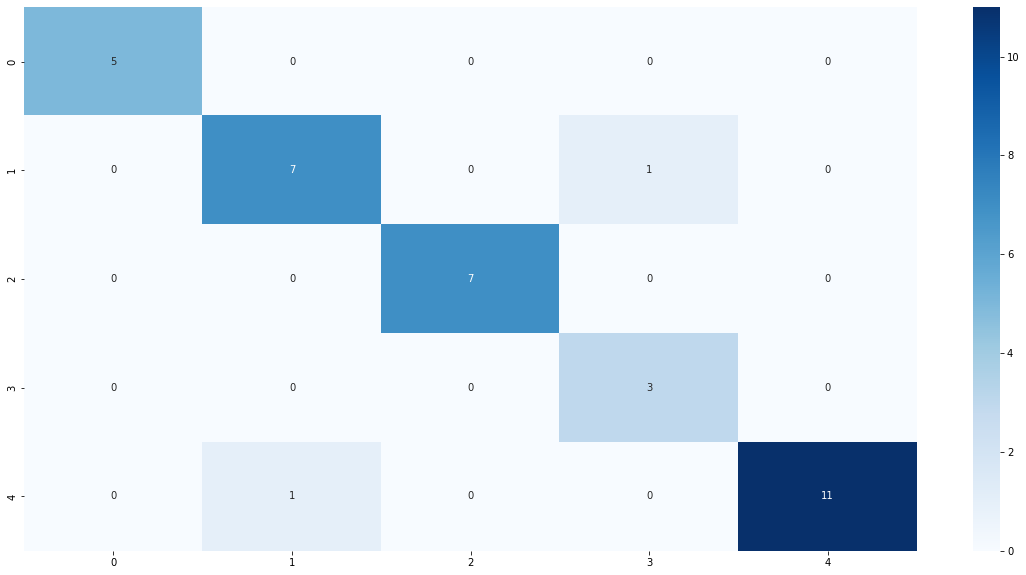

In [ ]:
plot_confusion_matrix(outputs_test,inputs_test)

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
def plot_motion(i, predictions_array, true_label, data):
  true_label, motion = true_label[i], data[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.plot(range(1,SAMPLES_PER_GESTURE+1), motion, linestyle='solid', marker=',')

  predicted_label = predictions_array.argmax()
  if predicted_label == true_label.argmax():
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(GESTURES[predicted_label],
                                100*np.max(predictions_array),
                                GESTURES[true_label.argmax()]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label.argmax(axis=1)[i]
  plt.grid(False)
  plt.xticks(range(5))
  plt.yticks([])
  thisplot = plt.bar(range(5), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

def show_sample(label=outputs_train,data=inputs_train, num=6):
  num_rows = np.ceil(num/2)
  num_cols = 2
  num_images = num_rows*num_cols
  predictions = model.predict(data)
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))
  for i in range(num):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_motion(i, predictions[i], label, data)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], label)
  plt.tight_layout()
  plt.show()

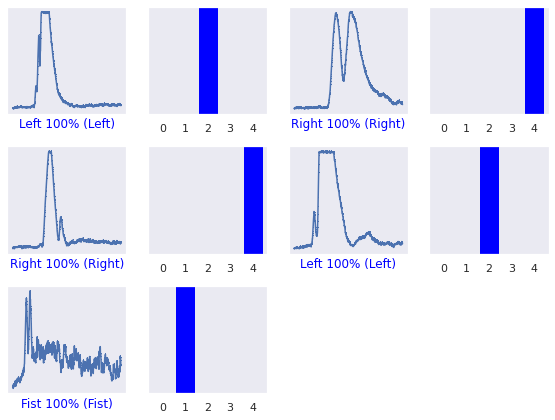

In [ ]:
show_sample(outputs_test, inputs_test, 5)

# Convert the Trained Model to Tensor Flow Lite

> Indented block



The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

INFO:tensorflow:Assets written to: /tmp/tmpvyksh2j6/assets


Model is 153436 bytes


In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

INFO:tensorflow:Assets written to: /tmp/tmpveh199rs/assets


INFO:tensorflow:Assets written to: /tmp/tmpveh199rs/assets


Model is 153436 bytes


## Encode the Model in an Arduino Header File 

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 946,224 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


# Classifying IMU Data

Now it's time to switch back to the tutorial instructions and run our new model on the Arduino Nano 33 BLE Sense to classify the accelerometer and gyroscope data.
